# Fitbit Performance Analysis

Analyze workout performance with detailed heart rate zones, activity metrics, and full-day context.

**Features:**
- Detailed workout timeline with HR zones
- Full day context view
- Multiple workout comparison
- Configurable date selection

## 1. Setup and Imports

In [79]:
import json
import gzip
import pandas as pd
from datetime import datetime, timedelta
import boto3
from io import BytesIO
import matplotlib.pyplot as plt
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [80]:
# Import custom functions
from functions.import_data import parse_fitbit_data
from functions.performance_functions import (
    plot_performance_timeline,
    plot_full_day_with_workout_highlight,
    plot_multiple_workouts_comparison,
    calculate_hr_zones_from_age,
    DEFAULT_HR_ZONES,
    PLOT_CONFIG
)

## 2. Connect to S3

In [81]:
# S3 Configuration
session = boto3.Session(profile_name='surface')
s3 = session.client('s3')
bucket_name = 'followcrom'
prefix = 'cromwell/fitbit/'

## 3. List Available Files

In [82]:
try:
    s3response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    files = [obj['Key'] for obj in s3response.get('Contents', []) if obj['Key'].endswith('.json.gz')]
    
    print(f"Found {len(files)} backup files")
    print(f"\nMost recent files:")
    for f in files[-5:]:
        print(f"  - {f}")
except Exception as e:
    print(f"Error listing S3 files: {e}")

Found 44 backup files

Most recent files:
  - cromwell/fitbit/fitbit_backup_2025-11-11.json.gz
  - cromwell/fitbit/fitbit_backup_2025-11-12.json.gz
  - cromwell/fitbit/fitbit_backup_2025-11-13.json.gz
  - cromwell/fitbit/fitbit_backup_2025-11-14.json.gz
  - cromwell/fitbit/fitbit_backup_2025-11-15.json.gz


## 4. Select Date to Analyze

Change the date below to analyze different days

In [83]:
# CONFIGURE: Set the date you want to analyze
target_date = '2025-11-04'

# Or use yesterday:
# target_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

file_key = f'{prefix}fitbit_backup_{target_date}.json.gz'
print(f"Analyzing data for: {target_date}")
print(f"File: {file_key}")

Analyzing data for: 2025-11-04
File: cromwell/fitbit/fitbit_backup_2025-11-04.json.gz


## 5. Load and Parse Data

In [84]:
try:
    response = s3.get_object(Bucket=bucket_name, Key=file_key)
    with gzip.GzipFile(fileobj=BytesIO(response['Body'].read())) as f:
        data = json.load(f)
    print(f"✅ Loaded {len(data):,} records from S3")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

✅ Loaded 39,403 records from S3


In [85]:
# Parse all data into DataFrames
dfs = parse_fitbit_data(data)

# Display summary
print("\n📊 Available DataFrames:")
print("="*70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")


📊 Available DataFrames:
HeartRate_Intraday             |  37891 records
Steps_Intraday                 |   1440 records
HRV                            |      1 records
BreathingRate                  |      1 records
SkinTemperature                |      1 records
SPO2_Daily                     |      1 records
Activity-minutesSedentary      |      1 records
Activity-minutesLightlyActive  |      1 records
Activity-minutesFairlyActive   |      1 records
Activity-minutesVeryActive     |      1 records
Activity-steps                 |      1 records
Activity-calories              |      1 records
Activity-distance              |      1 records
HR_Zones                       |      1 records
RestingHR                      |      1 records
SleepSummary                   |      1 records
SleepLevels                    |     55 records
DeviceBatteryLevel             |      1 records
ActivityRecords                |      2 records


In [86]:
# Extract required DataFrames
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())
df_activity_records = dfs.get('ActivityRecords', pd.DataFrame())

print(f"\n✅ Found {len(df_hr_intra):,} HeartRate_Intraday records")
print(f"✅ Found {len(df_steps_intra):,} Steps_Intraday records")
print(f"✅ Found {len(df_activity_records)} Activity records")

# Check if we have activities
if len(df_activity_records) == 0:
    print("\n⚠️  No activities found for this date")
else:
    print(f"\n📋 Activities:")
    for idx, row in df_activity_records.iterrows():
        duration_min = row['duration'] / 1000 / 60
        print(f"  {idx+1}. {row['ActivityName']:15s} - {duration_min:.0f} min at {row['time']}")


✅ Found 37,891 HeartRate_Intraday records
✅ Found 1,440 Steps_Intraday records
✅ Found 2 Activity records

📋 Activities:
  1. Swim            - 37 min at 2025-11-04 20:03:16+00:00
  2. Walk            - 25 min at 2025-11-04 20:46:29+00:00


## 6. Detailed Workout Analysis

View detailed performance timeline for a specific workout

In [87]:
# OPTIONAL: Calculate personalized HR zones based on age
# Uncomment and set your age to use personalized zones
# my_age = 35
# my_resting_hr = 60
# hr_zones = calculate_hr_zones_from_age(my_age, my_resting_hr)

# Use default zones
hr_zones = DEFAULT_HR_ZONES

print("Heart Rate Zones:")
for zone, info in hr_zones.items():
    print(f"  {zone:15s}: {info['range'][0]:3d} - {info['range'][1]:3d} bpm")

Heart Rate Zones:
  Out of Range   :   0 -  93 bpm
  Fat Burn       :  93 - 128 bpm
  Cardio         : 128 - 155 bpm
  Peak           : 155 - 220 bpm


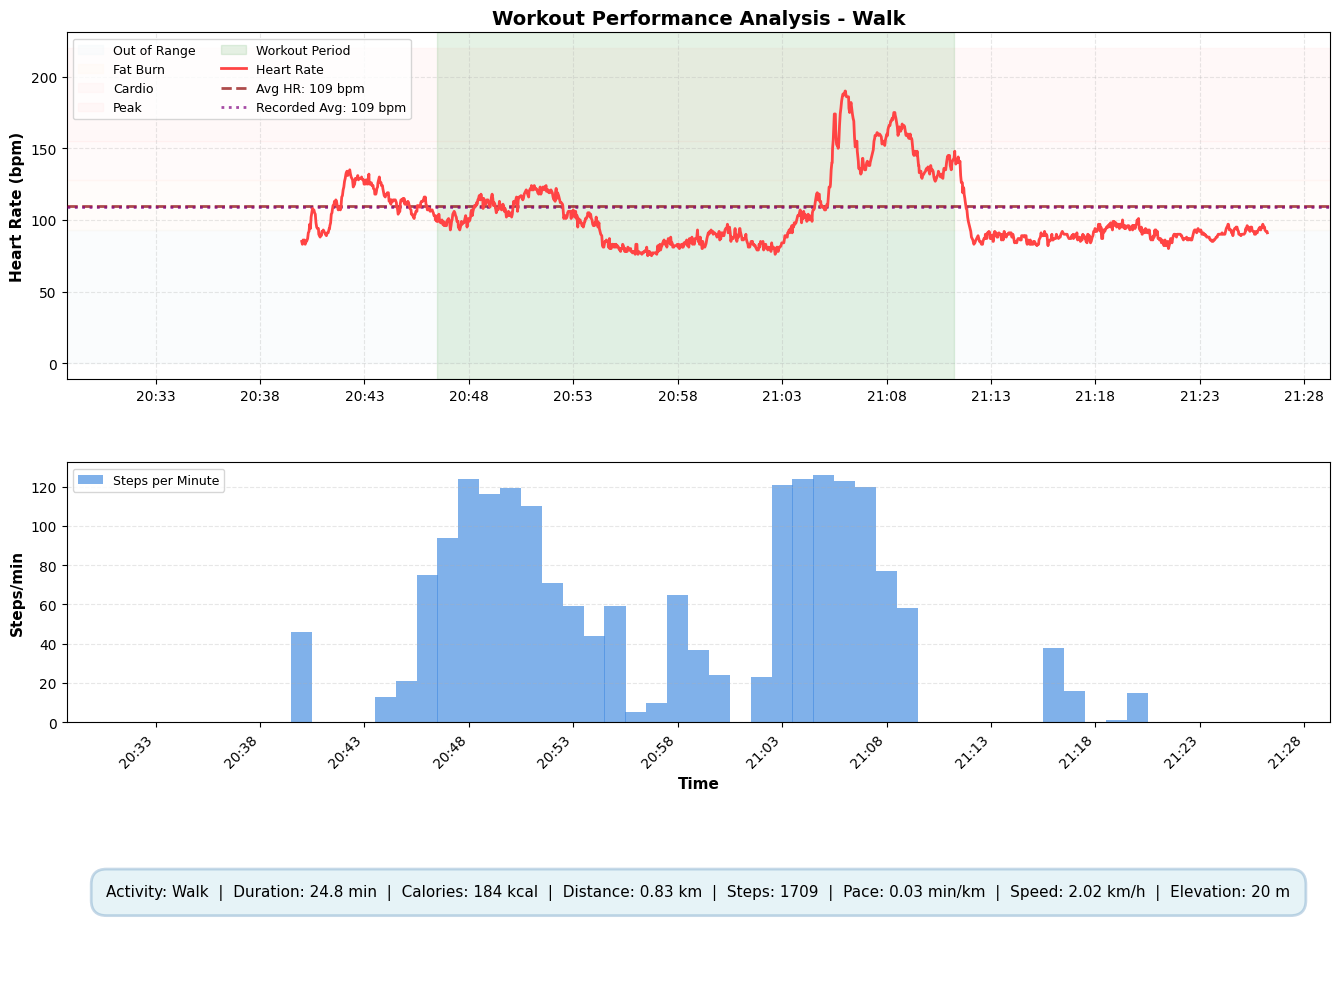

In [88]:
# Select which activity to analyze (0 = first, 1 = second, etc.)
activity_index = 1

if len(df_activity_records) > 0:
    try:
        selected_activity = df_activity_records.iloc[activity_index]
        
        fig = plot_performance_timeline(
            df_hr_intra,
            df_steps_intra,
            selected_activity,
            hr_zones=hr_zones,
            timezone='Europe/London'
        )
        plt.show()
    except IndexError:
        print(f"❌ Activity index {activity_index} not found. Available: 0-{len(df_activity_records)-1}")
    except Exception as e:
        print(f"❌ Error plotting: {e}")
else:
    print("❌ No activities to plot")

## 7. Full Day Context View

View the entire day with workout highlighted

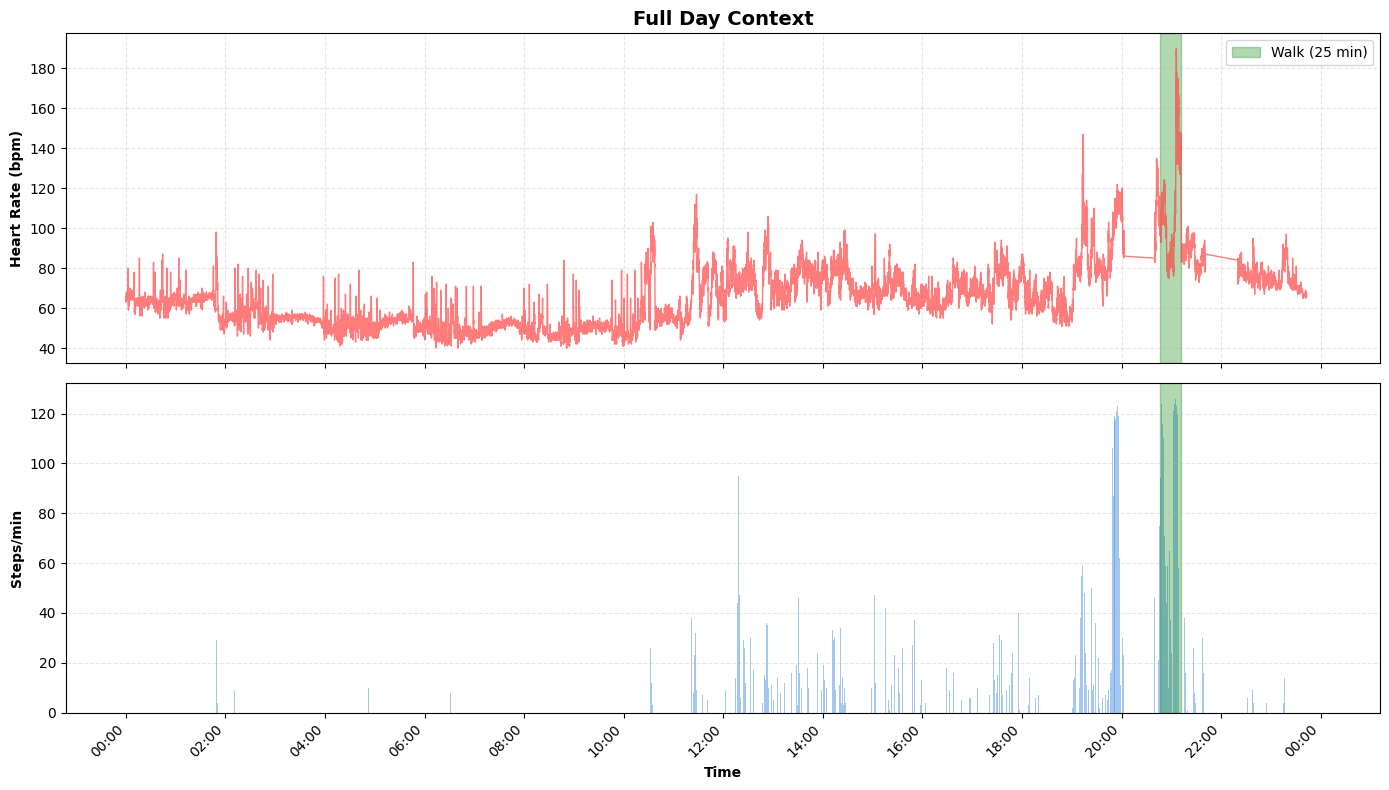

In [89]:
if len(df_activity_records) > 0:
    try:
        fig = plot_full_day_with_workout_highlight(
            df_hr_intra,
            df_steps_intra,
            df_activity_records.iloc[activity_index],
            timezone='Europe/London'
        )
        plt.show()
    except Exception as e:
        print(f"❌ Error plotting: {e}")
else:
    print("❌ No activities to plot")

## 8. Multiple Workouts Comparison (Optional)

Compare multiple workouts from the same day

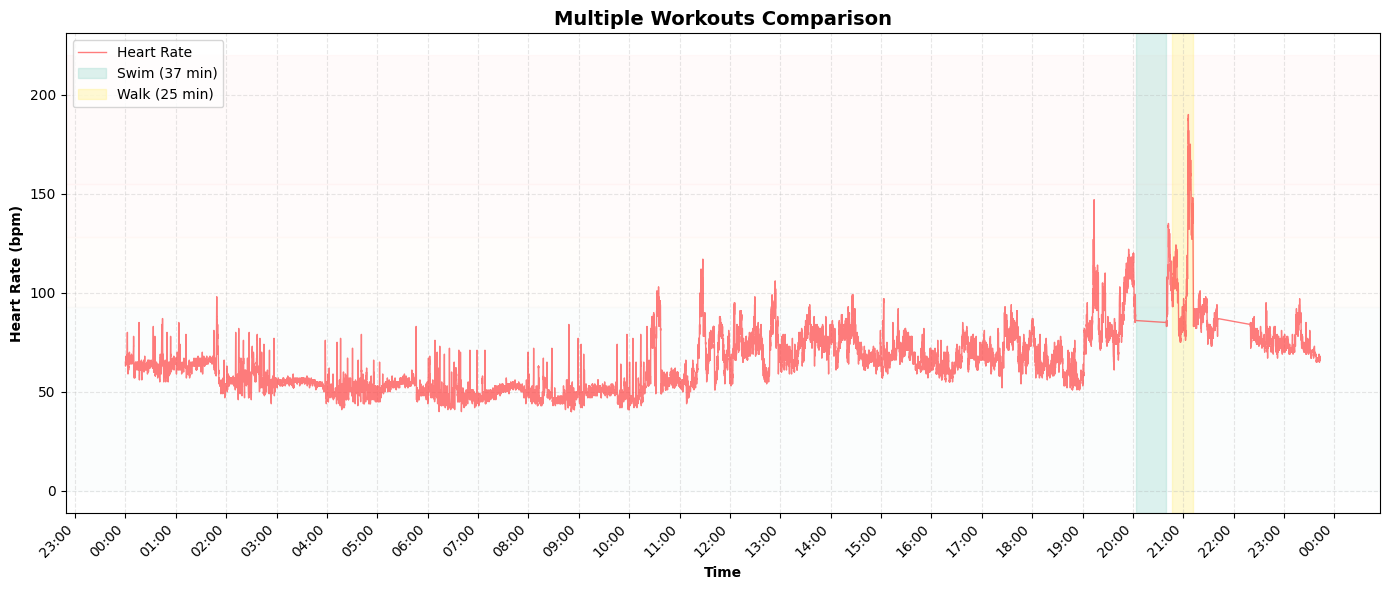

In [90]:
if len(df_activity_records) > 1:
    try:
        fig = plot_multiple_workouts_comparison(
            df_hr_intra,
            df_steps_intra,
            df_activity_records,
            hr_zones=hr_zones,
            timezone='Europe/London'
        )
        plt.show()
    except Exception as e:
        print(f"❌ Error plotting: {e}")
else:
    print("Only one activity found - comparison requires multiple workouts")

## 9. Activity Details

View detailed metrics for all activities

In [91]:
if len(df_activity_records) > 0:
    # Select relevant columns
    cols_to_show = [
        'time', 'ActivityName', 'calories', 'distance', 'steps',
        'speed', 'pace', 'averageHeartRate', 'duration',
        'elevationGain'
    ]
    
    # Filter columns that exist
    available_cols = [col for col in cols_to_show if col in df_activity_records.columns]
    
    print("\n📊 Activity Details:")
    print("="*100)
    display(df_activity_records[available_cols])
else:
    print("No activities found")


📊 Activity Details:


,time,ActivityName,calories,distance,steps,speed,pace,averageHeartRate,duration,elevationGain
0,2025-11-04 20:03:16+00:00,Swim,279.0,0.947591,NaN,1.550603,2321.676757,NaN,2200000.0,0.0
1,2025-11-04 20:46:29+00:00,Walk,184.0,0.832265,1709.0,2.017612,1784.287457,109.0,1485000.0,20.0


## 10. Swim-Specific Analysis

Detailed analysis for swimming sessions including pace per 100m, GPS data, and heart rate during swim

**⚠️ Known Issue:** Fitbit API returns swim distances in **miles** (not km like other activities). This notebook converts them correctly, but `fitbit2s3.py` should be updated to handle this at the data collection stage for future consistency.

In [92]:
# Configuration
POOL_LENGTH = 25  # meters
MILES_TO_KM = 1.609344  # Conversion factor

# Find all swim activities
swim_activities = df_activity_records[df_activity_records['ActivityName'] == 'Swim'].copy()

if len(swim_activities) > 0:
    print(f"Found {len(swim_activities)} swim session(s)\n")
    
    for idx, swim in swim_activities.iterrows():
        print(f"{'='*80}")
        print(f"SWIM SESSION ANALYSIS - {swim['time']}")
        print(f"{'='*80}\n")
        
        # FIX: Fitbit API returns swim distances in MILES, not kilometers!
        # Convert to meters correctly
        distance_from_api = swim['distance']  # This is in MILES for swimming
        distance_m = distance_from_api * MILES_TO_KM * 1000  # Convert miles -> km -> meters
        distance_km = distance_m / 1000
        
        print(f"⚠️ Note: Fitbit returns swim distance in miles ({distance_from_api:.3f} mi)")
        print(f"📏 Distance: {distance_m:.0f} meters ({distance_km:.2f} km)")
        
        # Duration
        duration_min = swim['duration'] / 1000 / 60
        duration_sec = swim['duration'] / 1000
        
        print(f"⏱️ Duration: {duration_min:.1f} minutes ({duration_sec:.0f} seconds)")
        print(f"🔥 Calories: {swim['calories']:.0f} kcal")
        
        # Recalculate speed with correct distance
        speed_kmh = (distance_km / duration_sec) * 3600
        print(f"⚡ Speed: {speed_kmh:.2f} km/h\n")
        
        # Calculate pace per 100m with CORRECT distance
        pace_sec_per_100m = duration_sec / (distance_m / 100)
        pace_min = int(pace_sec_per_100m // 60)
        pace_sec = int(pace_sec_per_100m % 60)
        
        print(f"🏊 Pace per 100m: {pace_min}:{pace_sec:02d} min/100m")
        
        # Laps in 25m pool
        laps = distance_m / POOL_LENGTH
        complete_laps = int(laps)
        
        print(f"\n🔄 Laps ({POOL_LENGTH}m pool): {laps:.1f} laps ({complete_laps} complete laps)")
        
        # Length breakdown
        complete_lengths = int(distance_m / POOL_LENGTH)
        remaining_meters = distance_m % POOL_LENGTH
        print(f"   = {complete_lengths} lengths", end='')
        if remaining_meters >= 1:
            print(f" + {remaining_meters:.0f}m")
        else:
            print()
        
        # Average time per lap
        if complete_laps > 0:
            sec_per_lap = duration_sec / laps
            lap_min = int(sec_per_lap // 60)
            lap_sec = int(sec_per_lap % 60)
            print(f"   Average time per lap: {lap_min}:{lap_sec:02d}")
        
        print(f"\n📊 Additional Metrics:")
        print(f"   Calories per 100m: {(swim['calories'] / (distance_m / 100)):.1f} kcal")
        print(f"   Meters per minute: {distance_m / duration_min:.1f} m/min")
        
        print(f"\n")
else:
    print("No swim activities found for this date")

Found 1 swim session(s)

SWIM SESSION ANALYSIS - 2025-11-04 20:03:16+00:00

⚠️  Note: Fitbit returns swim distance in miles (0.948 mi)
📏 Distance: 1525 meters (1.52 km)
⏱️  Duration: 36.7 minutes (2200 seconds)
🔥 Calories: 279 kcal
⚡ Speed: 2.50 km/h

🏊 Pace per 100m: 2:24 min/100m

🔄 Laps (25m pool): 61.0 laps (60 complete laps)
   = 60 lengths + 25m
   Average time per lap: 0:36

📊 Additional Metrics:
   Calories per 100m: 18.3 kcal
   Meters per minute: 41.6 m/min




In [93]:
# Debug: Search for ANY records containing "Swim"
print("="*80)
print("SEARCHING FOR SWIM IN RAW DATA")
print("="*80)

swim_found = False
for i, record in enumerate(data):
    # Check if "Swim" appears anywhere in the record
    record_str = str(record)
    if 'Swim' in record_str or 'swim' in record_str:
        if not swim_found:
            print(f"\nFound swim-related record at index {i}:")
            print(f"Measurement: {record.get('measurement')}")
            print(f"Time: {record.get('time')}")
            print(f"\nFull record:")
            import json
            print(json.dumps(record, indent=2))
            swim_found = True
            break

if not swim_found:
    print("\nNo swim records found. Let me check what measurement types exist...")
    measurement_types = set()
    for record in data:
        measurement_types.add(record.get('measurement'))
    
    print(f"\nAll measurement types in data:")
    for mt in sorted(measurement_types):
        count = sum(1 for r in data if r.get('measurement') == mt)
        print(f"  {mt:30s}: {count:5d} records")

SEARCHING FOR SWIM IN RAW DATA

Found swim-related record at index 39402:
Measurement: ActivityRecords
Time: 2025-11-04T20:03:16+00:00

Full record:
{
  "measurement": "ActivityRecords",
  "time": "2025-11-04T20:03:16+00:00",
  "tags": {
    "ActivityName": "Swim"
  },
  "fields": {
    "calories": 279.0,
    "distance": 0.947591,
    "speed": 1.5506034545454543,
    "pace": 2321.6767571663304,
    "duration": 2200000.0,
    "activeDuration": 2200000.0,
    "inProgress": 0.0,
    "originalDuration": 2200000.0,
    "elevationGain": 0.0,
    "hasActiveZoneMinutes": 1.0
  }
}


In [94]:
# Check for GPS data
df_gps = dfs.get('GPS', pd.DataFrame())

if not df_gps.empty:
    print(f"✅ Found {len(df_gps)} GPS trackpoints\n")
    print(df_gps.head(10))
else:
    print("⚠️  No GPS data found (expected for pool swimming)\n")

# Check if there's heart rate data during swim sessions
if len(swim_activities) > 0 and not df_hr_intra.empty:
    print(f"\n{'='*80}")
    print("HEART RATE DURING SWIM")
    print(f"{'='*80}\n")
    
    for idx, swim in swim_activities.iterrows():
        # Extract activity time window
        from functions.performance_functions import extract_activity_time_window
        swim_start, swim_end, duration = extract_activity_time_window(swim, 'Europe/London')
        
        # Filter HR data to swim window
        hr_during_swim = df_hr_intra[
            (df_hr_intra['time'] >= swim_start) & 
            (df_hr_intra['time'] <= swim_end)
        ].copy()
        
        if not hr_during_swim.empty:
            print(f"Swim at {swim['time']}:")
            print(f"  ✅ Found {len(hr_during_swim)} heart rate measurements during swim")
            print(f"  📊 HR Statistics:")
            print(f"     - Average: {hr_during_swim['value'].mean():.1f} bpm")
            print(f"     - Min: {hr_during_swim['value'].min():.0f} bpm")
            print(f"     - Max: {hr_during_swim['value'].max():.0f} bpm")
            print(f"     - Median: {hr_during_swim['value'].median():.1f} bpm\n")
            
            # Show HR distribution
            print(f"  HR Zone Distribution:")
            for zone_name, zone_info in hr_zones.items():
                hr_in_zone = hr_during_swim[
                    (hr_during_swim['value'] >= zone_info['range'][0]) &
                    (hr_during_swim['value'] < zone_info['range'][1])
                ]
                pct = (len(hr_in_zone) / len(hr_during_swim)) * 100
                print(f"     - {zone_name:15s}: {pct:5.1f}% ({len(hr_in_zone):4d} measurements)")
        else:
            print(f"  ⚠️  No heart rate data found during swim (watch may not track HR in water)\n")

⚠️  No GPS data found (expected for pool swimming)


HEART RATE DURING SWIM

  ⚠️  No heart rate data found during swim (watch may not track HR in water)



Plotting swim session from 2025-11-04 20:03:16+00:00



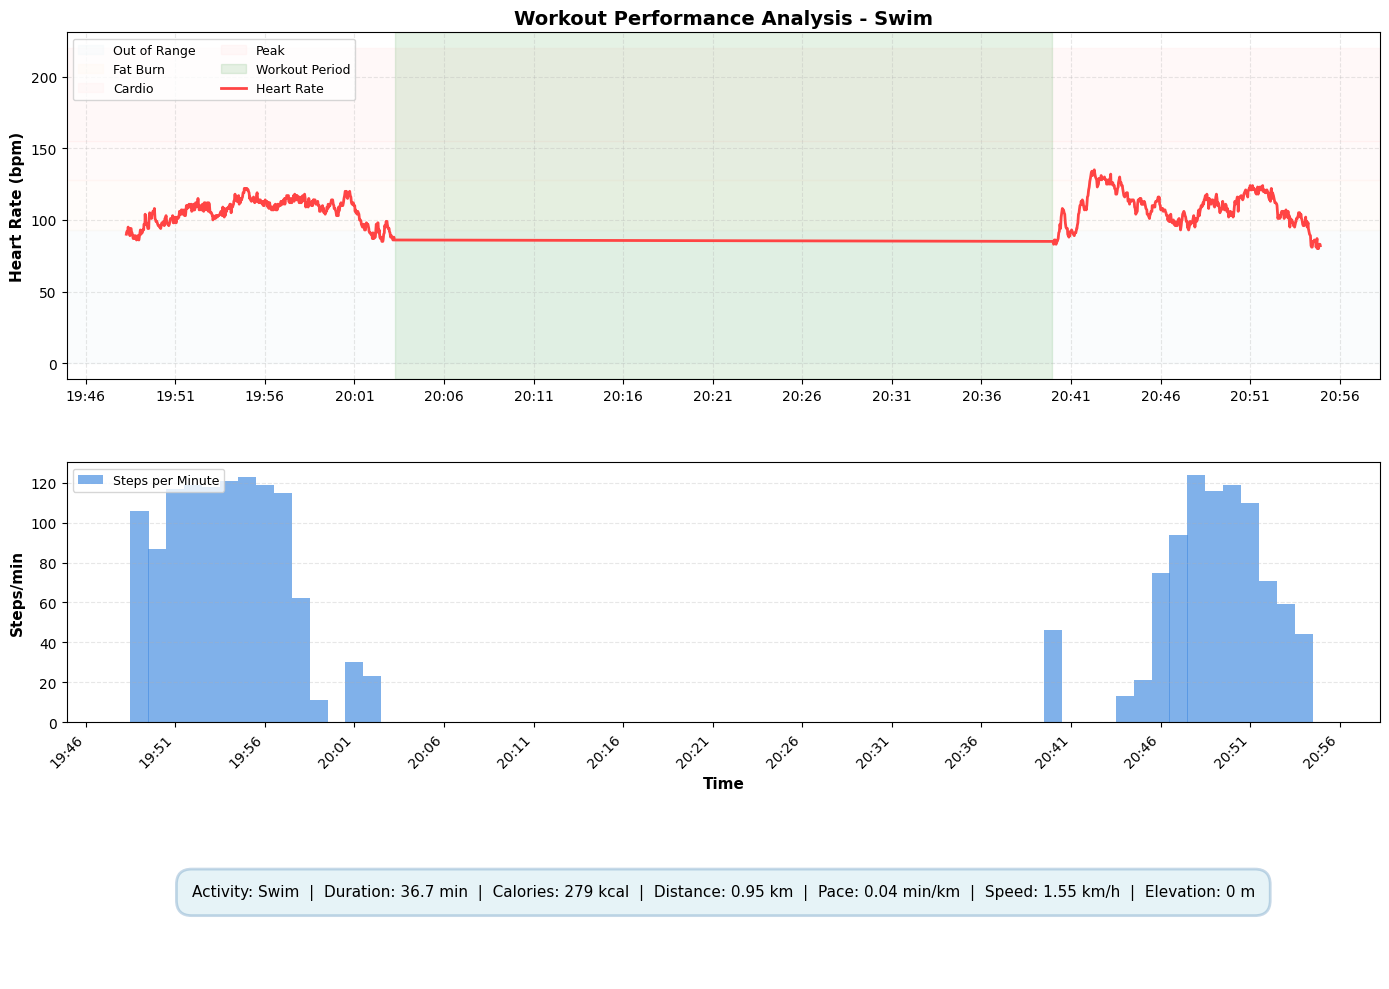

In [95]:
# Plot swim session if activity_index points to a swim
if len(df_activity_records) > 0:
    # Check if we have any swim in the records
    swim_indices = df_activity_records[df_activity_records['ActivityName'] == 'Swim'].index.tolist()
    
    if len(swim_indices) > 0:
        # Use the first swim activity
        swim_idx = 0  # Change this to analyze different swim sessions
        
        try:
            selected_swim = df_activity_records.iloc[swim_idx]
            
            if selected_swim['ActivityName'] == 'Swim':
                print(f"Plotting swim session from {selected_swim['time']}\n")
                
                fig = plot_performance_timeline(
                    df_hr_intra,
                    df_steps_intra,
                    selected_swim,
                    hr_zones=hr_zones,
                    timezone='Europe/London'
                )
                plt.show()
            else:
                print(f"Activity at index {swim_idx} is not a swim session (it's {selected_swim['ActivityName']})")
                print(f"Swim sessions are at indices: {swim_indices}")
        except Exception as e:
            print(f"Error plotting swim: {e}")
    else:
        print("No swim sessions found to plot")

## 11. Heart Rate Zone Analysis

Visualize time spent in different heart rate zones throughout the day

Analyzing 37,891 heart rate measurements



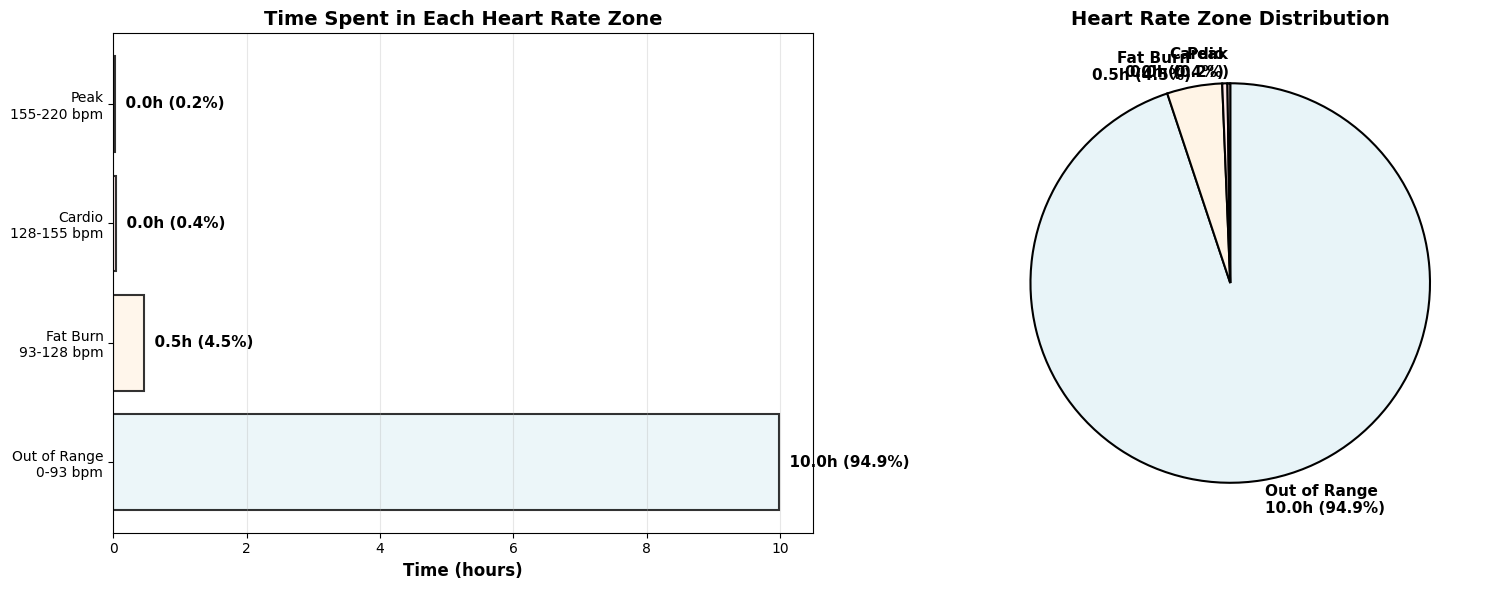


HEART RATE ZONE SUMMARY

Out of Range    (0-93 bpm)
  Time: 10.0 hours (599 minutes)
  Percentage: 94.9%
  Measurements: 35,957

Fat Burn        (93-128 bpm)
  Time: 0.5 hours (28 minutes)
  Percentage: 4.5%
  Measurements: 1,691

Cardio          (128-155 bpm)
  Time: 0.0 hours (3 minutes)
  Percentage: 0.4%
  Measurements: 159

Peak            (155-220 bpm)
  Time: 0.0 hours (1 minutes)
  Percentage: 0.2%
  Measurements: 84

OVERALL STATISTICS
Total measurements: 37,891
Average HR: 65.6 bpm
Min HR: 40 bpm
Max HR: 190 bpm
Median HR: 64.0 bpm


In [96]:
import numpy as np

if not df_hr_intra.empty:
    print(f"Analyzing {len(df_hr_intra):,} heart rate measurements\n")
    
    # Calculate time in each zone
    zone_data = []
    zone_colors = []
    
    for zone_name, zone_info in hr_zones.items():
        hr_in_zone = df_hr_intra[
            (df_hr_intra['value'] >= zone_info['range'][0]) &
            (df_hr_intra['value'] < zone_info['range'][1])
        ]
        
        # Each measurement is ~1 second apart for HR data
        minutes_in_zone = len(hr_in_zone) / 60
        hours_in_zone = minutes_in_zone / 60
        percentage = (len(hr_in_zone) / len(df_hr_intra)) * 100
        
        zone_data.append({
            'zone': zone_name,
            'count': len(hr_in_zone),
            'minutes': minutes_in_zone,
            'hours': hours_in_zone,
            'percentage': percentage,
            'color': zone_info['color'],
            'range': f"{zone_info['range'][0]}-{zone_info['range'][1]} bpm"
        })
        zone_colors.append(zone_info['color'])
    
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ========================================================================
    # Left panel: Bar chart
    # ========================================================================
    
    zones = [z['zone'] for z in zone_data]
    hours = [z['hours'] for z in zone_data]
    colors = [z['color'] for z in zone_data]
    
    bars = ax1.barh(zones, hours, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels on bars
    for i, (bar, zone_info) in enumerate(zip(bars, zone_data)):
        width = bar.get_width()
        label = f"{zone_info['hours']:.1f}h ({zone_info['percentage']:.1f}%)"
        ax1.text(width, bar.get_y() + bar.get_height()/2, 
                f'  {label}', 
                va='center', fontsize=11, fontweight='bold')
    
    ax1.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
    ax1.set_title('Time Spent in Each Heart Rate Zone', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add zone ranges as y-tick labels
    ax1.set_yticks(range(len(zones)))
    ax1.set_yticklabels([f"{z['zone']}\n{z['range']}" for z in zone_data])
    
    # ========================================================================
    # Right panel: Pie chart
    # ========================================================================
    
    # Only include zones with non-zero time
    non_zero_zones = [z for z in zone_data if z['hours'] > 0]
    
    if non_zero_zones:
        pie_labels = [f"{z['zone']}\n{z['hours']:.1f}h ({z['percentage']:.1f}%)" 
                      for z in non_zero_zones]
        pie_values = [z['hours'] for z in non_zero_zones]
        pie_colors = [z['color'] for z in non_zero_zones]
        
        wedges, texts = ax2.pie(pie_values, 
                                labels=pie_labels,
                                colors=pie_colors,
                                startangle=90,
                                counterclock=False,
                                wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
                                textprops={'fontsize': 11, 'fontweight': 'bold'})
        
        ax2.set_title('Heart Rate Zone Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("HEART RATE ZONE SUMMARY")
    print("="*80)
    
    for z in zone_data:
        print(f"\n{z['zone']:15s} ({z['range']})")
        print(f"  Time: {z['hours']:.1f} hours ({z['minutes']:.0f} minutes)")
        print(f"  Percentage: {z['percentage']:.1f}%")
        print(f"  Measurements: {z['count']:,}")
    
    # Overall stats
    print(f"\n{'='*80}")
    print("OVERALL STATISTICS")
    print(f"{'='*80}")
    print(f"Total measurements: {len(df_hr_intra):,}")
    print(f"Average HR: {df_hr_intra['value'].mean():.1f} bpm")
    print(f"Min HR: {df_hr_intra['value'].min():.0f} bpm")
    print(f"Max HR: {df_hr_intra['value'].max():.0f} bpm")
    print(f"Median HR: {df_hr_intra['value'].median():.1f} bpm")
    
else:
    print("No heart rate data available")

HEART RATE ZONES BY ACTIVITY



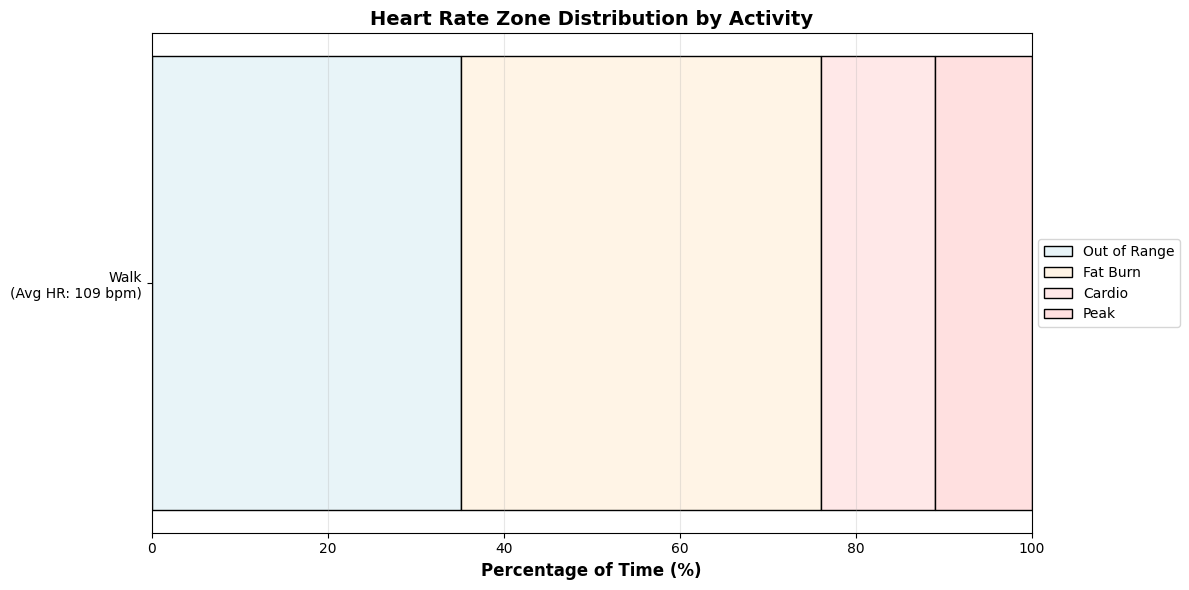


Activity Comparison:

Walk (2025-11-04 20:46:29+00:00):
  Average HR: 109.4 bpm
  Max HR: 190 bpm
  Measurements: 768
  Zone breakdown:
    Out of Range   :  35.2%
    Fat Burn       :  40.9%
    Cardio         :  13.0%
    Peak           :  10.9%


In [97]:
# Optional: Compare HR zones between different activities
if len(df_activity_records) > 0 and not df_hr_intra.empty:
    print("="*80)
    print("HEART RATE ZONES BY ACTIVITY")
    print("="*80 + "\n")
    
    from functions.performance_functions import extract_activity_time_window
    
    # Create comparison data
    activity_zone_data = []
    
    for idx, activity in df_activity_records.iterrows():
        activity_start, activity_end, duration = extract_activity_time_window(activity, 'Europe/London')
        
        # Get HR data during this activity
        hr_during_activity = df_hr_intra[
            (df_hr_intra['time'] >= activity_start) & 
            (df_hr_intra['time'] <= activity_end)
        ]
        
        if not hr_during_activity.empty:
            # Calculate zone percentages
            zone_percentages = {}
            for zone_name, zone_info in hr_zones.items():
                hr_in_zone = hr_during_activity[
                    (hr_during_activity['value'] >= zone_info['range'][0]) &
                    (hr_during_activity['value'] < zone_info['range'][1])
                ]
                pct = (len(hr_in_zone) / len(hr_during_activity)) * 100
                zone_percentages[zone_name] = pct
            
            activity_zone_data.append({
                'name': activity['ActivityName'],
                'time': activity['time'],
                'zones': zone_percentages,
                'avg_hr': hr_during_activity['value'].mean(),
                'max_hr': hr_during_activity['value'].max(),
                'measurements': len(hr_during_activity)
            })
    
    if activity_zone_data:
        # Create stacked bar chart
        fig, ax = plt.subplots(figsize=(12, 6))
        
        zone_names = list(hr_zones.keys())
        num_activities = len(activity_zone_data)
        
        # Prepare data for stacked bars
        bottom = np.zeros(num_activities)
        
        for zone_name in zone_names:
            percentages = [a['zones'][zone_name] for a in activity_zone_data]
            zone_color = hr_zones[zone_name]['color']
            
            ax.barh(range(num_activities), percentages, left=bottom, 
                   label=zone_name, color=zone_color, edgecolor='black', linewidth=1)
            bottom += percentages
        
        # Customize plot
        activity_labels = [f"{a['name']}\n(Avg HR: {a['avg_hr']:.0f} bpm)" 
                          for a in activity_zone_data]
        ax.set_yticks(range(num_activities))
        ax.set_yticklabels(activity_labels)
        ax.set_xlabel('Percentage of Time (%)', fontsize=12, fontweight='bold')
        ax.set_title('Heart Rate Zone Distribution by Activity', fontsize=14, fontweight='bold')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True, alpha=0.3, axis='x')
        ax.set_xlim(0, 100)
        
        plt.tight_layout()
        plt.show()
        
        # Print comparison
        print("\nActivity Comparison:")
        for a in activity_zone_data:
            print(f"\n{a['name']} ({a['time']}):")
            print(f"  Average HR: {a['avg_hr']:.1f} bpm")
            print(f"  Max HR: {a['max_hr']:.0f} bpm")
            print(f"  Measurements: {a['measurements']:,}")
            print(f"  Zone breakdown:")
            for zone_name, pct in a['zones'].items():
                if pct > 0:
                    print(f"    {zone_name:15s}: {pct:5.1f}%")
    else:
        print("No heart rate data found during activities")
else:
    print("No activities with heart rate data to compare")

FITBIT vs. CALCULATED HR ZONES COMPARISON



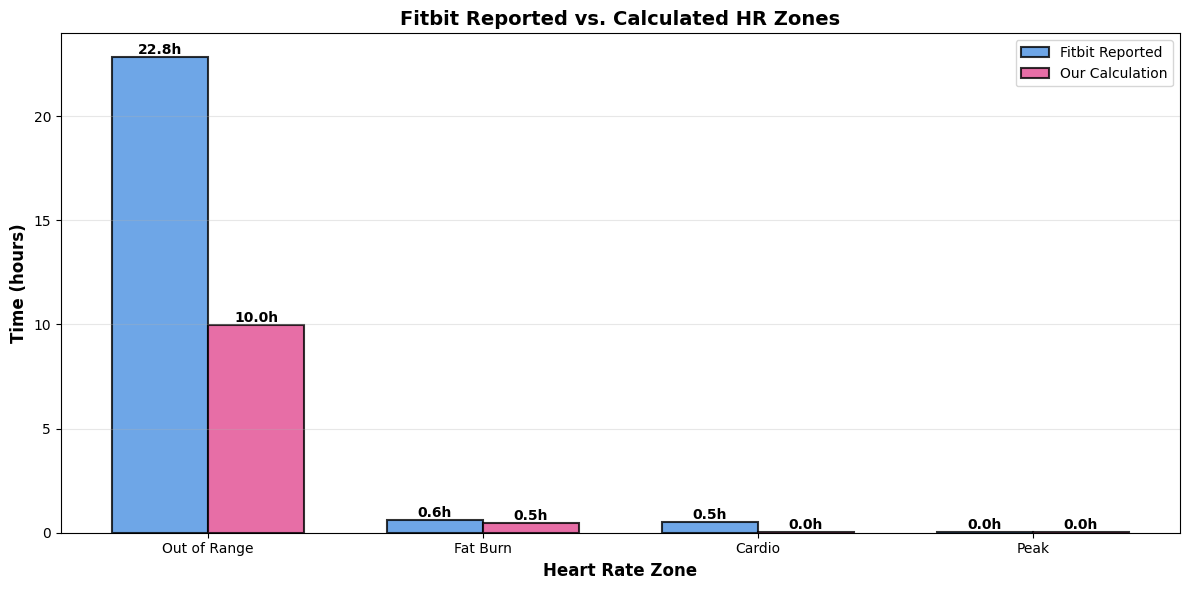


Detailed Comparison:
Zone            |     Fitbit | Calculated | Difference
------------------------------------------------------------
Out of Range    |    1370 min |     599 min |    -771 min
Fat Burn        |      36 min |      28 min |      -8 min
Cardio          |      32 min |       3 min |     -29 min
Peak            |       2 min |       1 min |      -1 min

Note: Differences may occur because:
  - Fitbit uses different zone thresholds based on your profile
  - We're using generic zones (customize with calculate_hr_zones_from_age)
  - Timing differences in data collection


In [101]:
# Compare our calculated zones vs. Fitbit's reported HR_Zones
df_hr_zones_fitbit = dfs.get('HR_Zones', pd.DataFrame())

if not df_hr_zones_fitbit.empty:
    print("="*80)
    print("FITBIT vs. CALCULATED HR ZONES COMPARISON")
    print("="*80 + "\n")
    
    # Get Fitbit's reported zone data
    fitbit_zones = df_hr_zones_fitbit.iloc[0]
    
    # Prepare comparison data
    comparison_data = []
    
    for zone_name in ['Out of Range', 'Fat Burn', 'Cardio', 'Peak']:
        # Fitbit's reported minutes
        fitbit_minutes = fitbit_zones.get(zone_name, 0)
        fitbit_hours = fitbit_minutes / 60
        
        # Our calculated minutes
        calculated_zone = next((z for z in zone_data if z['zone'] == zone_name), None)
        if calculated_zone:
            calculated_minutes = calculated_zone['minutes']
            calculated_hours = calculated_zone['hours']
        else:
            calculated_minutes = 0
            calculated_hours = 0
        
        # Calculate difference
        diff_minutes = calculated_minutes - fitbit_minutes
        diff_hours = diff_minutes / 60
        
        comparison_data.append({
            'zone': zone_name,
            'fitbit_minutes': fitbit_minutes,
            'fitbit_hours': fitbit_hours,
            'calculated_minutes': calculated_minutes,
            'calculated_hours': calculated_hours,
            'diff_minutes': diff_minutes,
            'diff_hours': diff_hours
        })
    
    # Create comparison bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    zones = [c['zone'] for c in comparison_data]
    x = np.arange(len(zones))
    width = 0.35
    
    fitbit_hours = [c['fitbit_hours'] for c in comparison_data]
    calculated_hours = [c['calculated_hours'] for c in comparison_data]
    
    bars1 = ax.bar(x - width/2, fitbit_hours, width, 
                   label='Fitbit Reported', color='#4A90E2', 
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    bars2 = ax.bar(x + width/2, calculated_hours, width, 
                   label='Our Calculation', color='#E24A90', 
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}h',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Heart Rate Zone', fontsize=12, fontweight='bold')
    ax.set_ylabel('Time (hours)', fontsize=12, fontweight='bold')
    ax.set_title('Fitbit Reported vs. Calculated HR Zones', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(zones)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\nDetailed Comparison:")
    print(f"{'Zone':15s} | {'Fitbit':>10s} | {'Calculated':>10s} | {'Difference':>10s}")
    print("-" * 60)
    
    for c in comparison_data:
        diff_sign = "+" if c['diff_minutes'] >= 0 else ""
        print(f"{c['zone']:15s} | {c['fitbit_minutes']:7.0f} min | {c['calculated_minutes']:7.0f} min | {diff_sign}{c['diff_minutes']:7.0f} min")
    
    print("\nNote: Differences may occur because:")
    print("  - Fitbit uses different zone thresholds based on your profile")
    print("  - We're using generic zones (customize with calculate_hr_zones_from_age)")
    print("  - Timing differences in data collection")
    
else:
    print("No HR_Zones data available from Fitbit")

HEART RATE TIMELINE WITH ACTIVITIES



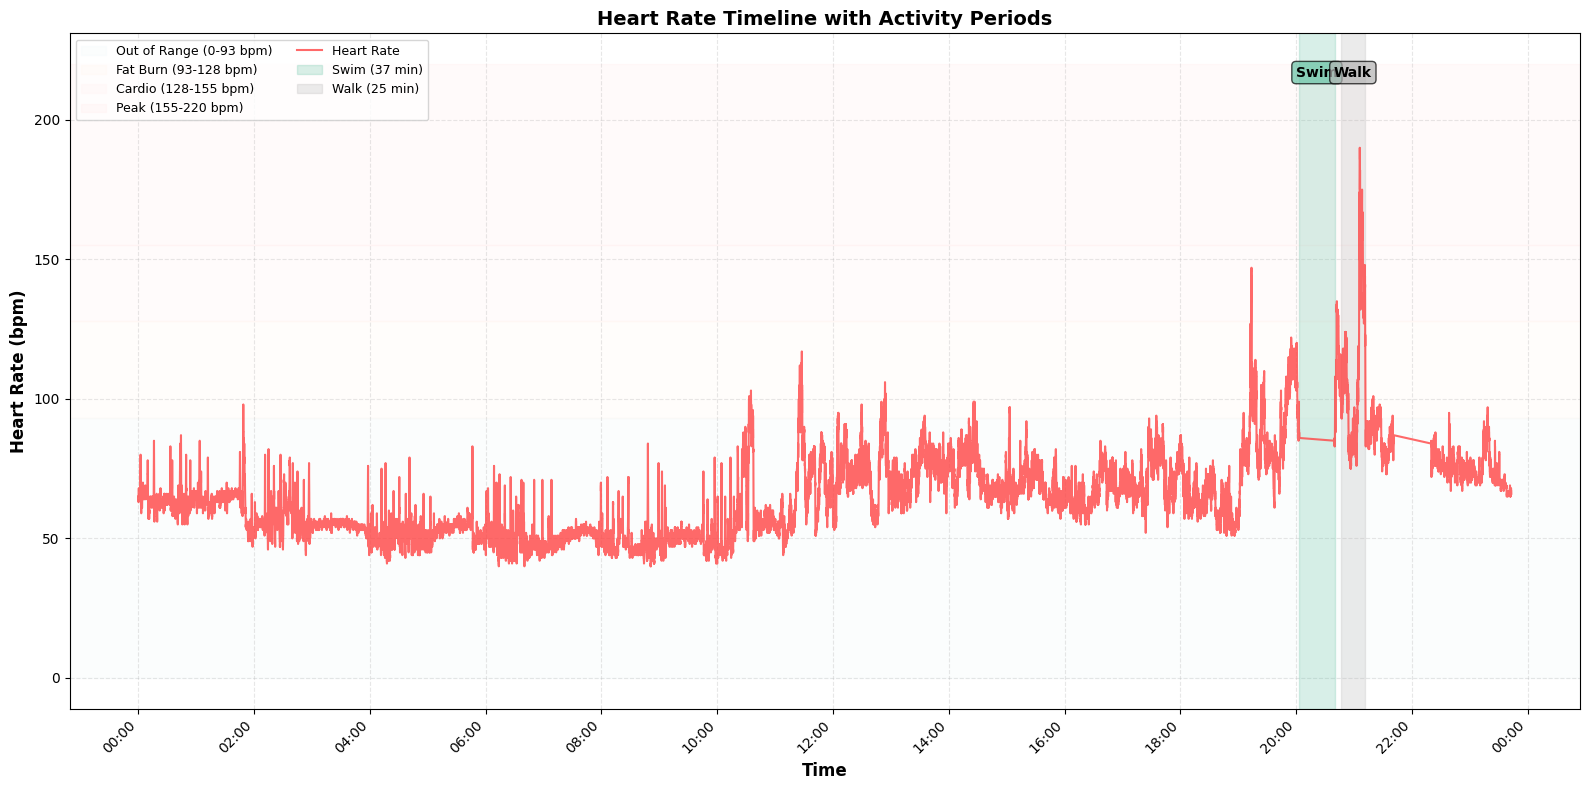


Timeline shows:
  - Colored bands: Heart rate zones
  - Red line: Your actual heart rate throughout the day
  - Highlighted regions: Activity periods
  - You can see how activities affect your HR and which zones you reached


In [100]:
# Timeline view: HR zones with activities highlighted
if not df_hr_intra.empty and len(df_activity_records) > 0:
    print("="*80)
    print("HEART RATE TIMELINE WITH ACTIVITIES")
    print("="*80 + "\n")
    
    from functions.performance_functions import convert_timezone_safe, extract_activity_time_window
    
    # Convert HR data to local timezone for plotting
    df_hr_plot = convert_timezone_safe(df_hr_intra.copy(), target_tz='Europe/London')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot HR zones as background bands
    for zone_name, zone_info in hr_zones.items():
        ax.axhspan(zone_info['range'][0], zone_info['range'][1], 
                  alpha=0.15, color=zone_info['color'], 
                  label=f"{zone_name} ({zone_info['range'][0]}-{zone_info['range'][1]} bpm)")
    
    # Plot heart rate line
    ax.plot(df_hr_plot['time'], df_hr_plot['value'], 
           color='#ff4444', linewidth=1.5, alpha=0.8, label='Heart Rate', zorder=5)
    
    # Highlight activity periods
    activity_colors = plt.cm.Set2(np.linspace(0, 1, len(df_activity_records)))
    
    for idx, (activity_idx, activity) in enumerate(df_activity_records.iterrows()):
        activity_start, activity_end, duration = extract_activity_time_window(activity, 'Europe/London')
        
        # Add vertical span for activity
        ax.axvspan(activity_start, activity_end, 
                  alpha=0.25, color=activity_colors[idx], 
                  label=f"{activity['ActivityName']} ({duration:.0f} min)", zorder=2)
        
        # Add text label at the top
        mid_time = activity_start + (activity_end - activity_start) / 2
        ax.text(mid_time, ax.get_ylim()[1] * 0.95, 
               activity['ActivityName'], 
               ha='center', va='top', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor=activity_colors[idx], alpha=0.7))
    
    # Customize plot
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold')
    ax.set_title('Heart Rate Timeline with Activity Periods', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Legend
    ax.legend(loc='upper left', fontsize=9, ncol=2)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTimeline shows:")
    print("  - Colored bands: Heart rate zones")
    print("  - Red line: Your actual heart rate throughout the day")
    print("  - Highlighted regions: Activity periods")
    print("  - You can see how activities affect your HR and which zones you reached")
    
else:
    print("Need both heart rate data and activity records for timeline view")

## 12. Activity Level Distribution

Analyze time spent at different activity levels: Sedentary, Lightly Active, Fairly Active, Very Active

ACTIVITY LEVEL DISTRIBUTION



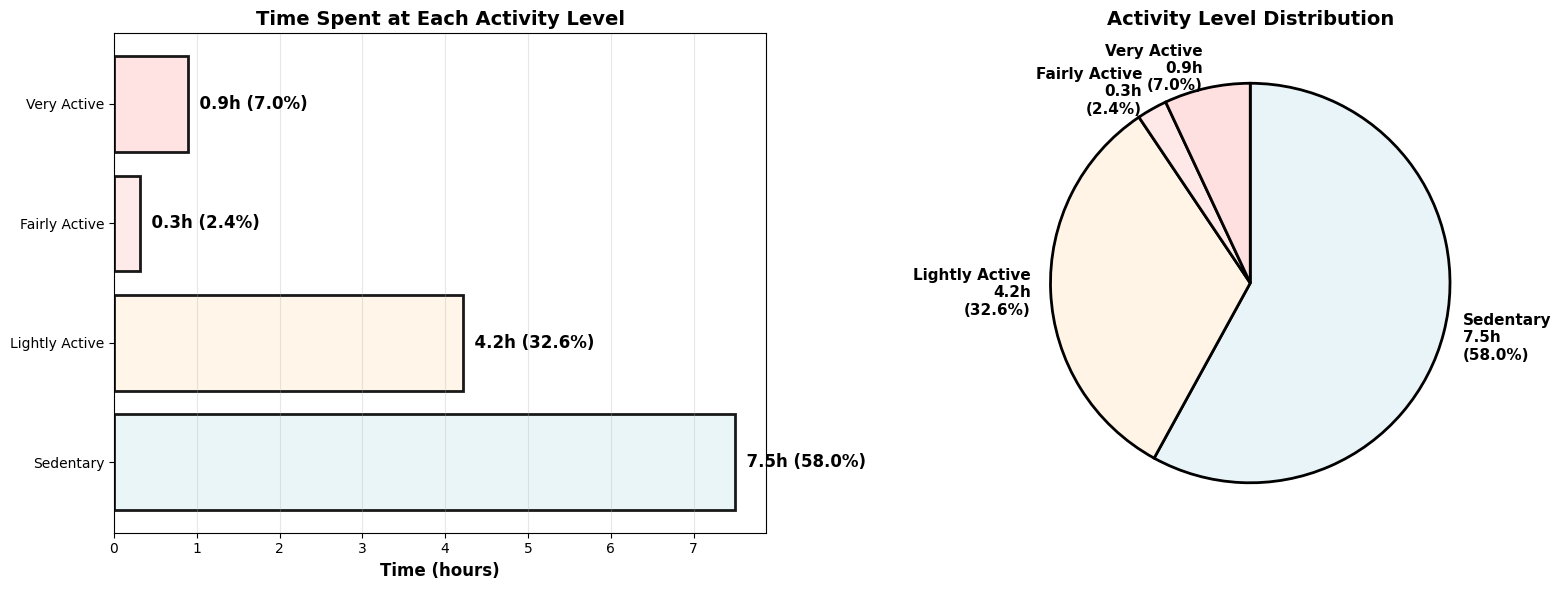


Activity Level Summary:

Sedentary           
  Time: 7.5 hours (450 minutes)
  Percentage of day: 58.0%

Lightly Active      
  Time: 4.2 hours (253 minutes)
  Percentage of day: 32.6%

Fairly Active       
  Time: 0.3 hours (19 minutes)
  Percentage of day: 2.4%

Very Active         
  Time: 0.9 hours (54 minutes)
  Percentage of day: 7.0%

Total tracked time: 12.9 hours (776 minutes)
Expected daily total: 24 hours (1440 minutes)
⚠️  Untracked time: 11.1 hours (664 minutes)
   This may be sleep or device-off time


In [98]:
# Extract activity level data
activity_levels = {
    'Sedentary': dfs.get('Activity-minutesSedentary', pd.DataFrame()),
    'Lightly Active': dfs.get('Activity-minutesLightlyActive', pd.DataFrame()),
    'Fairly Active': dfs.get('Activity-minutesFairlyActive', pd.DataFrame()),
    'Very Active': dfs.get('Activity-minutesVeryActive', pd.DataFrame())
}

# Check if we have activity level data
has_data = any(not df.empty for df in activity_levels.values())

if has_data:
    print("="*80)
    print("ACTIVITY LEVEL DISTRIBUTION")
    print("="*80 + "\n")
    
    # Collect data
    level_data = []
    total_minutes = 0
    
    # Define colors for activity levels
    level_colors = {
        'Sedentary': '#E8F4F8',
        'Lightly Active': '#FFF4E6',
        'Fairly Active': '#FFE8E8',
        'Very Active': '#FFE0E0'
    }
    
    for level_name, df in activity_levels.items():
        if not df.empty:
            minutes = df.iloc[0]['value']
            hours = minutes / 60
            total_minutes += minutes
            
            level_data.append({
                'level': level_name,
                'minutes': minutes,
                'hours': hours,
                'color': level_colors[level_name]
            })
    
    # Calculate percentages
    for item in level_data:
        item['percentage'] = (item['minutes'] / total_minutes) * 100 if total_minutes > 0 else 0
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ========================================================================
    # Left panel: Bar chart
    # ========================================================================
    
    levels = [item['level'] for item in level_data]
    hours = [item['hours'] for item in level_data]
    colors = [item['color'] for item in level_data]
    
    bars = ax1.barh(levels, hours, color=colors, edgecolor='black', linewidth=2, alpha=0.9)
    
    # Add value labels
    for bar, item in zip(bars, level_data):
        width = bar.get_width()
        label = f"{item['hours']:.1f}h ({item['percentage']:.1f}%)"
        ax1.text(width, bar.get_y() + bar.get_height()/2, 
                f'  {label}', 
                va='center', fontsize=12, fontweight='bold')
    
    ax1.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
    ax1.set_title('Time Spent at Each Activity Level', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # ========================================================================
    # Right panel: Pie chart
    # ========================================================================
    
    pie_labels = [f"{item['level']}\n{item['hours']:.1f}h\n({item['percentage']:.1f}%)" 
                  for item in level_data]
    pie_values = [item['hours'] for item in level_data]
    pie_colors = [item['color'] for item in level_data]
    
    wedges, texts = ax2.pie(pie_values,
                            labels=pie_labels,
                            colors=pie_colors,
                            startangle=90,
                            counterclock=False,
                            wedgeprops={'edgecolor': 'black', 'linewidth': 2},
                            textprops={'fontsize': 11, 'fontweight': 'bold'})
    
    ax2.set_title('Activity Level Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nActivity Level Summary:")
    print("="*60)
    
    for item in level_data:
        print(f"\n{item['level']:20s}")
        print(f"  Time: {item['hours']:.1f} hours ({item['minutes']:.0f} minutes)")
        print(f"  Percentage of day: {item['percentage']:.1f}%")
    
    print(f"\n{'='*60}")
    print(f"Total tracked time: {total_minutes/60:.1f} hours ({total_minutes:.0f} minutes)")
    print(f"Expected daily total: 24 hours (1440 minutes)")
    
    if total_minutes < 1440:
        untracked = 1440 - total_minutes
        print(f"⚠️  Untracked time: {untracked/60:.1f} hours ({untracked:.0f} minutes)")
        print(f"   This may be sleep or device-off time")
    
else:
    print("No activity level data available")


ACTIVITY LEVELS vs. HEART RATE ZONES COMPARISON



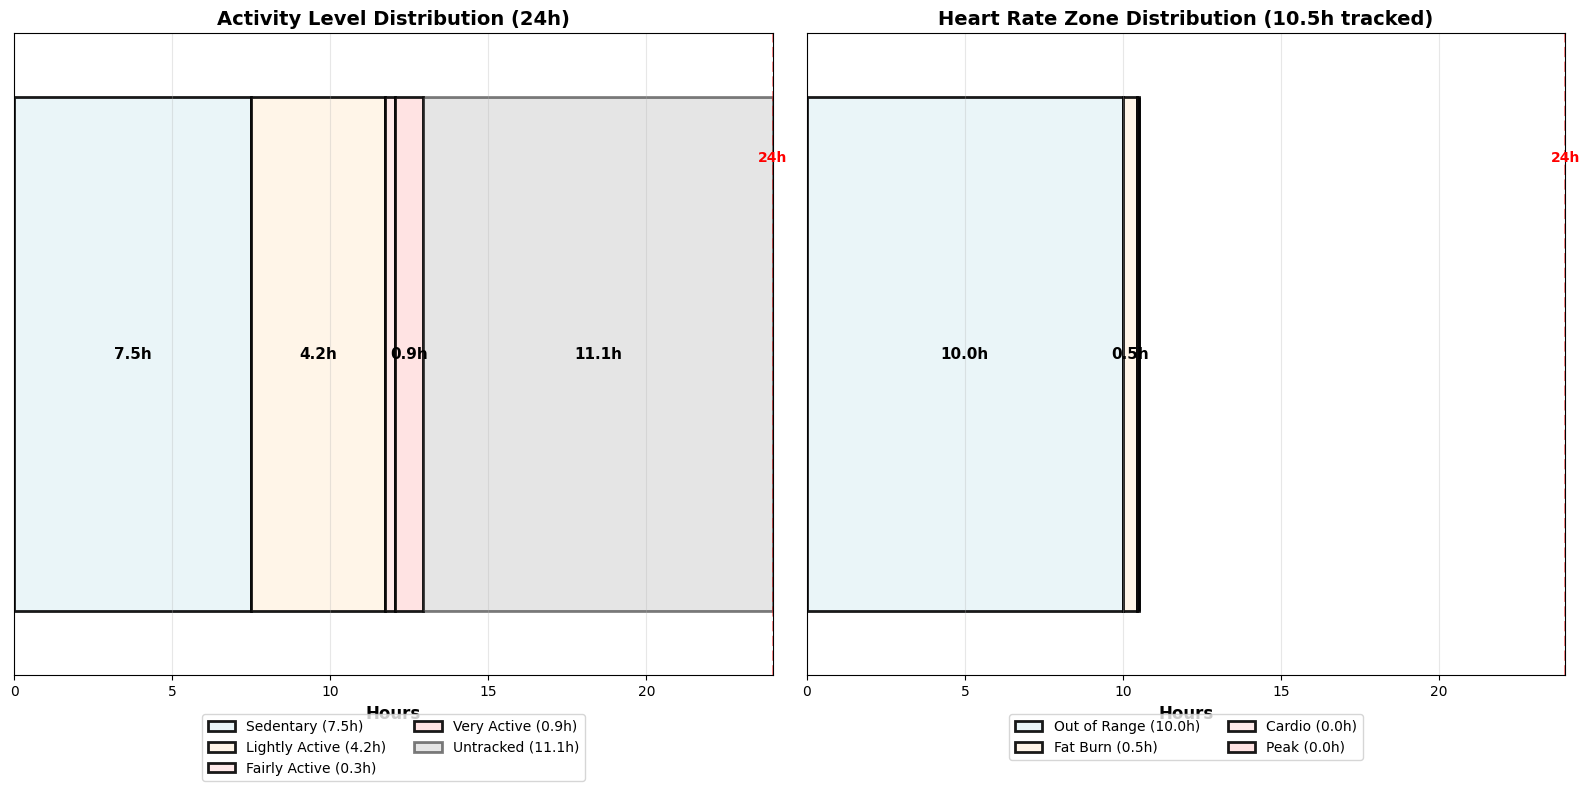


Key Insights:
------------------------------------------------------------

📊 Activity Summary:
   Total Active Time: 5.4 hours (22.6% of day)
   Sedentary Time: 7.5 hours (31.2% of day)

❤️  Heart Rate Summary:
   Elevated HR Time (Fat Burn+): 0.5 hours
   Percentage of tracked HR: 5.1%

🎯 Activity Goal (WHO Guidelines):
   Fairly/Very Active: 73 minutes
   Daily target: ~21 minutes
   ✅ Goal achieved! (341% of target)


In [99]:
# Combined view: Activity Levels vs HR Zones
if has_data and 'zone_data' in globals():
    print("\n" + "="*80)
    print("ACTIVITY LEVELS vs. HEART RATE ZONES COMPARISON")
    print("="*80 + "\n")
    
    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # ========================================================================
    # Left: Activity Levels (stacked with total 24h reference)
    # ========================================================================
    
    # Prepare data
    level_names = [item['level'] for item in level_data]
    level_hours = [item['hours'] for item in level_data]
    level_colors_list = [item['color'] for item in level_data]
    
    # Create stacked bar (horizontal)
    left = 0
    for i, (name, hours, color) in enumerate(zip(level_names, level_hours, level_colors_list)):
        ax1.barh(0, hours, left=left, color=color, 
                edgecolor='black', linewidth=2, alpha=0.9, 
                label=f"{name} ({hours:.1f}h)")
        
        # Add text label in the middle of each segment
        if hours > 0.5:  # Only show label if segment is wide enough
            ax1.text(left + hours/2, 0, f"{hours:.1f}h", 
                    ha='center', va='center', fontsize=11, fontweight='bold')
        
        left += hours
    
    # Add untracked time if any
    if total_minutes < 1440:
        untracked_hours = (1440 - total_minutes) / 60
        ax1.barh(0, untracked_hours, left=left, color='#CCCCCC', 
                edgecolor='black', linewidth=2, alpha=0.5, 
                label=f"Untracked ({untracked_hours:.1f}h)")
        if untracked_hours > 0.5:
            ax1.text(left + untracked_hours/2, 0, f"{untracked_hours:.1f}h", 
                    ha='center', va='center', fontsize=11, fontweight='bold')
    
    ax1.set_xlim(0, 24)
    ax1.set_ylim(-0.5, 0.5)
    ax1.set_xlabel('Hours', fontsize=12, fontweight='bold')
    ax1.set_title('Activity Level Distribution (24h)', fontsize=14, fontweight='bold')
    ax1.set_yticks([])
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add 24h marker
    ax1.axvline(24, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax1.text(24, 0.3, '24h', ha='center', fontsize=10, color='red', fontweight='bold')
    
    # ========================================================================
    # Right: HR Zones (stacked)
    # ========================================================================
    
    zone_names = [z['zone'] for z in zone_data]
    zone_hours = [z['hours'] for z in zone_data]
    zone_colors_list = [z['color'] for z in zone_data]
    
    # Create stacked bar (horizontal)
    left = 0
    total_hr_hours = sum(zone_hours)
    
    for i, (name, hours, color) in enumerate(zip(zone_names, zone_hours, zone_colors_list)):
        if hours > 0:
            ax2.barh(0, hours, left=left, color=color, 
                    edgecolor='black', linewidth=2, alpha=0.9, 
                    label=f"{name} ({hours:.1f}h)")
            
            # Add text label in the middle of each segment
            if hours > 0.3:  # Only show label if segment is wide enough
                ax2.text(left + hours/2, 0, f"{hours:.1f}h", 
                        ha='center', va='center', fontsize=11, fontweight='bold')
            
            left += hours
    
    ax2.set_xlim(0, 24)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_xlabel('Hours', fontsize=12, fontweight='bold')
    ax2.set_title(f'Heart Rate Zone Distribution ({total_hr_hours:.1f}h tracked)', 
                 fontsize=14, fontweight='bold')
    ax2.set_yticks([])
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add 24h marker
    ax2.axvline(24, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax2.text(24, 0.3, '24h', ha='center', fontsize=10, color='red', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Analysis
    print("\nKey Insights:")
    print("-" * 60)
    
    # Calculate active time
    active_time = sum(item['hours'] for item in level_data 
                     if item['level'] != 'Sedentary')
    sedentary_time = next((item['hours'] for item in level_data 
                          if item['level'] == 'Sedentary'), 0)
    
    print(f"\n📊 Activity Summary:")
    print(f"   Total Active Time: {active_time:.1f} hours ({(active_time/24)*100:.1f}% of day)")
    print(f"   Sedentary Time: {sedentary_time:.1f} hours ({(sedentary_time/24)*100:.1f}% of day)")
    
    # Calculate elevated HR time
    elevated_hr_zones = ['Fat Burn', 'Cardio', 'Peak']
    elevated_hr_time = sum(z['hours'] for z in zone_data 
                          if z['zone'] in elevated_hr_zones)
    
    print(f"\n❤️  Heart Rate Summary:")
    print(f"   Elevated HR Time (Fat Burn+): {elevated_hr_time:.1f} hours")
    print(f"   Percentage of tracked HR: {(elevated_hr_time/total_hr_hours)*100:.1f}%")
    
    # Activity goal check (WHO recommends 150 min moderate activity/week)
    fairly_very_active = sum(item['minutes'] for item in level_data 
                            if item['level'] in ['Fairly Active', 'Very Active'])
    daily_target = 150 / 7  # ~21.4 minutes per day
    
    print(f"\n🎯 Activity Goal (WHO Guidelines):")
    print(f"   Fairly/Very Active: {fairly_very_active:.0f} minutes")
    print(f"   Daily target: ~{daily_target:.0f} minutes")
    if fairly_very_active >= daily_target:
        print(f"   ✅ Goal achieved! ({(fairly_very_active/daily_target)*100:.0f}% of target)")
    else:
        shortfall = daily_target - fairly_very_active
        print(f"   ⚠️  {shortfall:.0f} minutes short of daily target")

else:
    print("Need both activity level and HR zone data for comparison")